In [ ]:
import csv
import os
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from garminconnect import Garmin


class ExerciseMapper:
    def __init__(self, mapping_file='exercise_to_muscle_group.csv'):
        self.mapping_file = mapping_file
        self.exercise_to_muscle_group = self._load_mapping()

    def _load_mapping(self):
        if os.path.exists(self.mapping_file):
            return pd.read_csv(self.mapping_file, index_col=0).to_dict()["Muscle Group"]
        else:
            # Default mapping
            return {
                "BENCH_PRESS": "Chest",
                "PUSH_UP": "Chest",
                "SIT_UP": "Core"
            }

    def save_mapping(self):
        pd.DataFrame.from_dict(self.exercise_to_muscle_group, orient='index', columns=['Muscle Group']).to_csv(self.mapping_file)

    def map_exercises(self, data):
        mapped_data = []
        for _, row in data.iterrows():
            category = row["Exercise"]
            if category not in self.exercise_to_muscle_group:
                self._add_new_exercise(category)

            muscle_group = self.exercise_to_muscle_group[category]
            mapped_data.append({
                "Muscle Group": muscle_group,
                "Exercise": category,
                "Reps": row["Reps"],
                "Sets": row["Sets"]
            })
        return mapped_data

    def _add_new_exercise(self, category):
        print(f"New exercise found: {category}")
        valid_muscle_groups = [
            "FrontQuadsRight", "FrontQuadsLeft", "Ab-AdductorsRight", "FrontHipsRight", "Ab-AductorsLeft", "FrontHipsLeft", "FrontAbsRight", "FrontAbsLeft", "FrontObliquesRight", "FrontObliquesLeft", "FrontChestRight""FrontChestLeft", "FrontDeltsRight", "FrontDeltsLeft", "FrontBicepsRight", "FrontBicepsLeft", "FrontForearmsRight", "FrontForearmsLeft", "BackCalvesRight", "BackCalvesLeft", "BackHamstringsRight", "BackHamstringsLeft", "BackAdductorsRight", "BackAdductorsLeft", "BackGlutesRight", "BackGlutesLeft", "BackAbductorsRight", "BackAbductorsLeft", "BackLowerbackRight", "BackLowerbackLeft", "BackLatsRight", "BackLatsLeft", "BackTrapsRight", "BackTrapsLeft", "BackDeltsRight", "BackDeltsLeft", "BackTricepsRight", "BackTricepsLeft", "BackForearmsRight", "BackForearmsLeft", "Undefined"
        ]
        print(f"Available muscle groups: {', '.join(valid_muscle_groups)}")
        while True:
            muscle_group = input(f"Please enter the muscle group for {category}: ")
            if muscle_group in valid_muscle_groups:
                break
            print("Invalid muscle group. Please choose from the available options.")

        self.exercise_to_muscle_group[category] = muscle_group
        self.save_mapping()


class GarminDataFetcher:
    def __init__(self, email, password):
        self.client = Garmin(email, password)
        try:
            self.client.login()
            print("Login successful")
        except Exception as e:
            print(f"Login failed: {e}")
            raise

    def fetch_data(self, start_date, end_date):
        delta = end_date - start_date
        total_days = delta.days + 1

        summarized_exercises = []
        for i in range(total_days):
            day = start_date + timedelta(days=i)
            day_str = day.strftime("%Y-%m-%d")
            print(f"Fetching activities for {day_str}...")
            try:
                activities = self.client.get_activities_by_date(day_str, day_str)
                strength_activities = [
                    activity for activity in activities
                    if activity.get('activityName', '') == 'Strength' and
                    activity.get('activityType', {}).get('typeKey', '') == 'strength_training'
                ]
                for activity in strength_activities:
                    if 'summarizedExerciseSets' in activity:
                        summarized_exercises.extend(activity['summarizedExerciseSets'])
            except Exception as e:
                print(f"Error fetching activities for {day_str}: {e}")
            time.sleep(1)  # Prevent rate limiting

        return pd.DataFrame(summarized_exercises)


class CSVDataFetcher:
    def __init__(self, file_path):
        self.file_path = file_path

    def fetch_data(self):
        if not os.path.exists(self.file_path):
            raise FileNotFoundError(f"The file {self.file_path} does not exist.")
        return pd.read_csv(self.file_path, delimiter=';')


class SpiderPlotter:
    @staticmethod
    def plot(mapped_data):
        df = pd.DataFrame(mapped_data)
        if df.empty:
            print("No data to plot.")
            return

        muscle_groups = df["Muscle Group"].unique()
        reps_per_group = df.groupby("Muscle Group")["Reps"].sum()

        # Prepare data for plotting
        labels = muscle_groups
        stats = reps_per_group.reindex(labels, fill_value=0).values

        # Number of variables
        num_vars = len(labels)

        # Split the circle into even parts and save the angles
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

        # Complete the circle
        stats = np.concatenate((stats, [stats[0]]))
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        ax.plot(angles, stats, linewidth=2, linestyle='solid')
        ax.fill(angles, stats, alpha=0.4)

        # Add labels
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels)

        plt.title("Muscle Group Activity", size=20, position=(0.5, 1.1))
        plt.show()


class CSVExporter:
    @staticmethod
    def save_to_csv(mapped_data, start_date, end_date):
        if not mapped_data:
            print("No data to save.")
            return

        filename = f"MappedStrengthTraining_{start_date}_{end_date}.csv"
        keys = mapped_data[0].keys()
        with open(filename, 'w', newline='') as output_file:
            dict_writer = csv.DictWriter(output_file, keys, delimiter=';')
            dict_writer.writeheader()
            dict_writer.writerows(mapped_data)
        print(f"Data saved to {filename}")


class StrengthTrainingAnalyzer:
    def __init__(self, source_type, email=None, password=None, csv_file=None):
        self.mapper = ExerciseMapper()
        if source_type == "api":
            self.fetcher = GarminDataFetcher(email, password)
        elif source_type == "csv":
            self.fetcher = CSVDataFetcher(csv_file)
        else:
            raise ValueError("Invalid source_type. Choose 'api' or 'csv'.")

    def run(self, start_date_str, end_date_str):
        start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
        end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

        fetched_data = self.fetcher.fetch_data()

        if fetched_data.empty:
            print("No strength training exercises found in the specified date range.")
            return

        mapped_data = self.mapper.map_exercises(fetched_data)

        SpiderPlotter.plot(mapped_data)

        CSVExporter.save_to_csv(
            mapped_data,
            start_date.strftime("%d.%m.%Y"),
            end_date.strftime("%d.%m.%Y")
        )


if __name__ == "__main__":
    source_type = input("Choose data source (api/csv): ").strip().lower()

    if source_type == "api":
        email = 'janicksteffen@hotmail.com'
        password = '07@Janick@98'
        analyzer = StrengthTrainingAnalyzer(source_type, email=email, password=password)
    elif source_type == "csv":
        csv_file = input("Enter the CSV file path: ")
        analyzer = StrengthTrainingAnalyzer(source_type, csv_file=csv_file)
    else:
        print("Invalid choice. Please choose 'api' or 'csv'.")
        exit()

    start_date = input("Enter the start date (YYYY-MM-DD): ")
    end_date = input("Enter the end date (YYYY-MM-DD): ")

    analyzer.run(start_date, end_date)


2024-12-01 16:38:30,035 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-01 16:38:30,040 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-01 16:38:30,060 [DEBUG] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-01 16:38:30,061 [DEBUG] findfont: score(FontEntry(fname='c:\\Users\\janic\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2024-12-01 16:38:30,061 [DEBUG] findfont: score(FontEntry(fname='c:\\Users\\janic\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-01 16:38

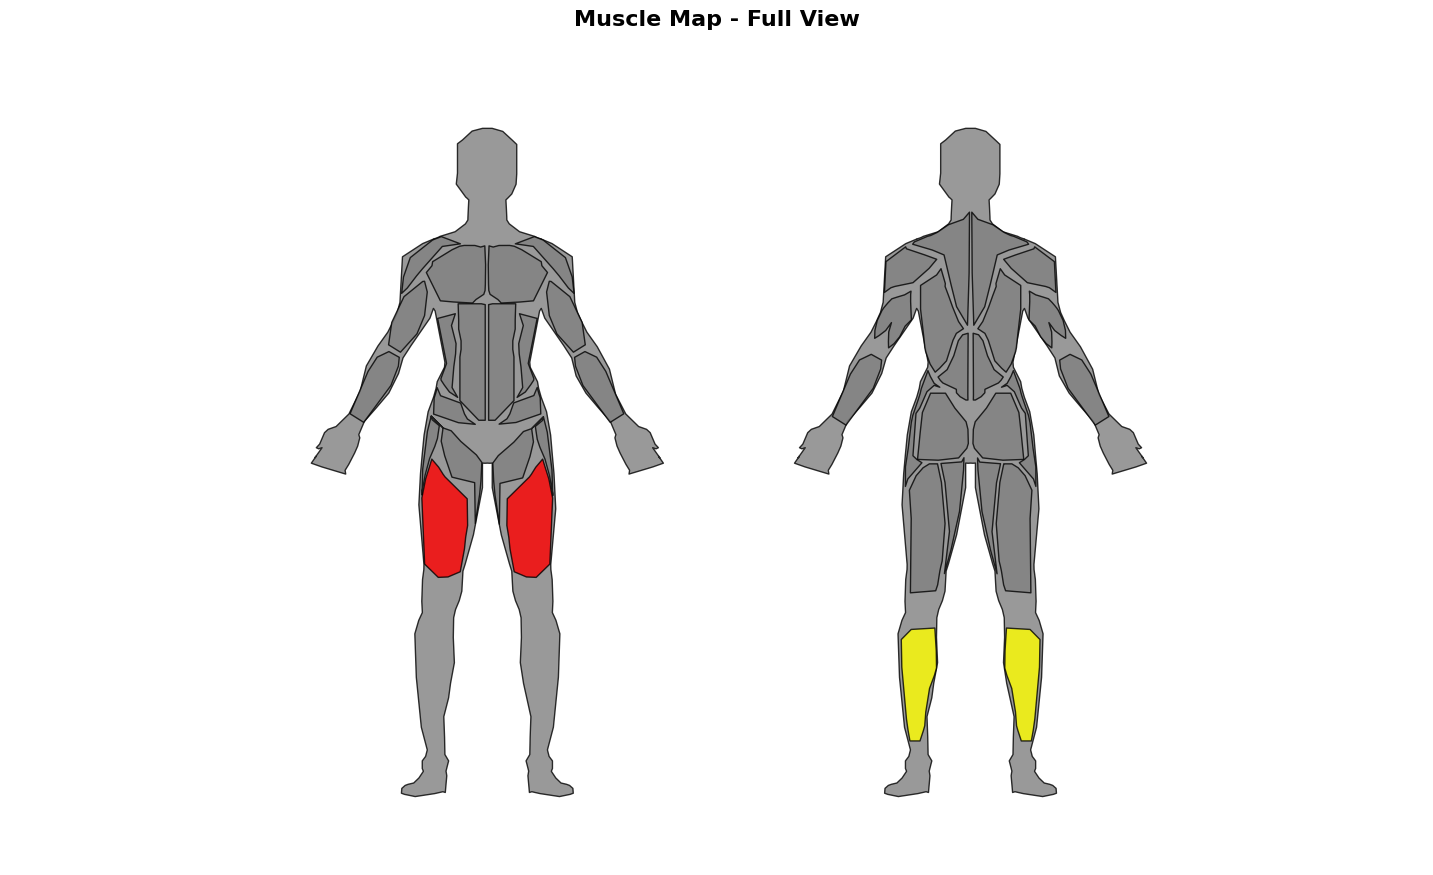

In [22]:
import json
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def parse_svg_path(d):
    """
    Parse raw SVG paths into coordinate lists.
    """
    path_data = re.findall(r"[-+]?[0-9]*\.?[0-9]+", d)
    coords = []
    for i in range(0, len(path_data), 2):
        x = float(path_data[i])
        y = float(path_data[i + 1])
        coords.append((x, -y))  # Negate y to match typical plot coordinates
    return coords

def apply_transformation(coords, transform):
    """
    Apply translation transformation to a list of coordinates.
    """
    translated_coords = [
        (x + transform.get("translateX", 0), y + transform.get("translateY", 0))
        for x, y in coords
    ]
    return translated_coords

def load_and_parse_muscle_coordinates(file_path):
    """
    Load muscle coordinates from a JSON file and apply transformations.
    """
    with open(file_path, 'r') as file:
        raw_data = json.load(file)

    parsed_data = {}
    for view, muscles in raw_data.items():
        parsed_data[view] = {}
        for muscle, paths in muscles.items():
            parsed_data[view][muscle] = []
            for path_data in paths:
                parsed_coords = parse_svg_path(path_data["path"])
                transformed_coords = apply_transformation(
                    parsed_coords, path_data.get("transform", {})
                )
                parsed_data[view][muscle].append({
                    "coords": transformed_coords,
                    "style": path_data["style"]
                })

    return parsed_data

def plot_muscle_map(muscle_data, primary_muscles, secondary_muscles, title, zoom_out_factor=1.5):
    """
    Plot the human body muscle map with zoom-out functionality.
    """
    fig, ax = plt.subplots(figsize=(19.8, 10.8))  # Set the window frame size

    # Adjust the limits to include the full figure range
    xlim = (-110 * zoom_out_factor, 400 * zoom_out_factor)
    ylim = (-25 * zoom_out_factor, 275 * zoom_out_factor)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_aspect('equal')
    ax.axis('off')  # Turn off axis

    patches = []  # To store all muscle group polygons
    colors = []   # To assign color for highlighting
    edge_colors = []

    for muscle, polygons in muscle_data.items():
        for polygon_data in polygons:
            polygon_coords = polygon_data["coords"]
            style = polygon_data["style"]

            # Create a polygon for the muscle group
            polygon = Polygon(polygon_coords, closed=True)
            patches.append(polygon)

            # Determine color based on muscle highlight
            if muscle in primary_muscles:
                colors.append('red') # Highlighted primary muscle color
            elif muscle in secondary_muscles:
                colors.append('yellow') # Highlighted secondary muscle color
            else:
                colors.append(style.get("fill", "lightgrey"))  # Default or provided fill color

            edge_colors.append(style.get("stroke", "black"))

    # Add patches to the plot
    patch_collection = PatchCollection(patches, edgecolor=edge_colors, linewidths=1, facecolor=colors, alpha=0.8)
    ax.add_collection(patch_collection)

    # Add title
    ax.set_title(title, fontsize=16, weight='bold')

    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and parse muscle coordinates with transformations
    muscle_coordinates = load_and_parse_muscle_coordinates("muscle_coordinates.json")

    # Specify highlighted muscles
    primary_muscles_front = ["FrontQuadsRight", "FrontQuadsLeft"]
    secondary_muscles_front = ["BackCalvesRight", "BackCalvesLeft"]

    # Plot the front view with zoom-out functionality
    plot_muscle_map(muscle_coordinates["Front"], primary_muscles_front, secondary_muscles_front, "Muscle Map - Full View", zoom_out_factor=3.0)


In [ ]:
import csv
import json
import os
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from garminconnect import Garmin


class ExerciseMapper:
    def __init__(self, mapping_file='exercise_to_muscle_group.csv'):
        self.mapping_file = mapping_file
        self.exercise_to_muscle_group = self._load_mapping()

    def _load_mapping(self):
        if os.path.exists(self.mapping_file):
            return pd.read_csv(self.mapping_file, index_col=0).to_dict(orient='index')
        else:
            return {}

    def save_mapping(self):
        pd.DataFrame.from_dict(
            self.exercise_to_muscle_group, orient='index', columns=['Primary', 'Secondary']
        ).to_csv(self.mapping_file)

    def map_exercises(self, data):
        mapped_data = []
        for exercise in data["summarizedExerciseSets"]:
            category = exercise["category"]
            if category not in self.exercise_to_muscle_group:
                self._add_new_exercise(category)

            muscle_groups = self.exercise_to_muscle_group[category]
            primary_muscle = muscle_groups["Primary"]
            secondary_muscle = muscle_groups.get("Secondary", "No Secondary")

            mapped_data.append({
                "Primary Muscle": primary_muscle,
                "Secondary Muscle": secondary_muscle,
                "Exercise": category,
                "Reps": exercise["reps"],
                "Sets": exercise["sets"]
            })
        return mapped_data

    def _add_new_exercise(self, category):
        print(f"New exercise found: {category}")
        valid_muscle_groups = [
            "FrontQuadsRight", "FrontQuadsLeft", "Ab-AdductorsRight", "FrontHipsRight", "Ab-AductorsLeft", "FrontHipsLeft", "FrontAbsRight", "FrontAbsLeft", "FrontObliquesRight", "FrontObliquesLeft", "FrontChestRight""FrontChestLeft", "FrontDeltsRight", "FrontDeltsLeft", "FrontBicepsRight", "FrontBicepsLeft", "FrontForearmsRight", "FrontForearmsLeft", "BackCalvesRight", "BackCalvesLeft", "BackHamstringsRight", "BackHamstringsLeft", "BackAdductorsRight", "BackAdductorsLeft", "BackGlutesRight", "BackGlutesLeft", "BackAbductorsRight", "BackAbductorsLeft", "BackLowerbackRight", "BackLowerbackLeft", "BackLatsRight", "BackLatsLeft", "BackTrapsRight", "BackTrapsLeft", "BackDeltsRight", "BackDeltsLeft", "BackTricepsRight", "BackTricepsLeft", "BackForearmsRight", "BackForearmsLeft", "Undefined"
        ]
        print(f"Available muscle groups: {', '.join(valid_muscle_groups)}")
        while True:
            primary = input(f"Enter the primary muscle group for {category}: ")
            if primary in valid_muscle_groups:
                break
            print("Invalid muscle group. Please choose from the available options.")

        secondary = input(f"Enter the secondary muscle group for {category} (or leave blank): ")
        if secondary and secondary not in valid_muscle_groups:
            print("Invalid muscle group. Defaulting to 'No Secondary'.")
            secondary = "No Secondary"

        self.exercise_to_muscle_group[category] = {"Primary": primary, "Secondary": secondary or "No Secondary"}
        self.save_mapping()


class GarminDataFetcher:
    def __init__(self, email, password):
        self.client = Garmin(email, password)
        try:
            # Attempt to log in
            self.client.login()
            profile = self.client.get_full_name()
            if not profile:
                raise AssertionError("Garmin profile not loaded.")
            print("Login successful.")
        except Exception as e:
            print(f"Standard login failed: {e}")
            print("Attempting MFA or debugging response...")
            self._debug_login()

    def _debug_login(self):
        """Debug and log additional details during login."""
        try:
            # Print raw response from the library
            response = self.client.garth.login(self.client.username, self.client.password)
            print(f"Raw login response: {response}")
        except Exception as e:
            print(f"Debugging login error: {e}")
            raise

    def fetch_data(self, start_date, end_date):
        delta = end_date - start_date
        total_days = delta.days + 1

        summarized_exercises = []
        for i in range(total_days):
            day = start_date + timedelta(days=i)
            day_str = day.strftime("%Y-%m-%d")
            print(f"Fetching activities for {day_str}...")
            try:
                activities = self.client.get_activities_by_date(day_str, day_str)
                strength_activities = [
                    activity for activity in activities
                    if activity.get('activityName', '') == 'Strength' and
                    activity.get('activityType', {}).get('typeKey', '') == 'strength_training'
                ]
                for activity in strength_activities:
                    if 'summarizedExerciseSets' in activity:
                        summarized_exercises.extend(activity['summarizedExerciseSets'])
            except Exception as e:
                print(f"Error fetching activities for {day_str}: {e}")
            time.sleep(1)  # Prevent rate limiting

        return {"summarizedExerciseSets": summarized_exercises}

    def logout(self):
        try:
            self.client.logout()
            print("Logout successful.")
        except Exception as e:
            print(f"Error during logout: {e}")


class MuscleMapPlotter:
    def __init__(self, muscle_coordinates_file):
        with open(muscle_coordinates_file, 'r') as file:
            self.muscle_coordinates = json.load(file)

    def plot_muscle_map(self, mapped_data, title):
        primary_reps = {}
        secondary_reps = {}

        # Aggregate reps per muscle group
        for entry in mapped_data:
            primary = entry["Primary Muscle"]
            secondary = entry["Secondary Muscle"]
            reps = entry["Reps"]

            if primary not in primary_reps:
                primary_reps[primary] = 0
            primary_reps[primary] += reps

            if secondary != "No Secondary" and secondary not in primary_reps:
                if secondary not in secondary_reps:
                    secondary_reps[secondary] = 0
                secondary_reps[secondary] += reps

        # Determine max reps for scaling
        max_primary_reps = max(primary_reps.values(), default=25)
        max_secondary_reps = max(secondary_reps.values(), default=25)

        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xlim(-100, 100)
        ax.set_ylim(-200, 200)
        ax.set_aspect('equal')
        ax.axis('off')

        for muscle_group, polygons in self.muscle_coordinates.items():
            for polygon_data in polygons:
                coords = polygon_data["coords"]
                style = polygon_data["style"]
                color = "grey"

                if muscle_group in primary_reps:
                    intensity = primary_reps[muscle_group] / max_primary_reps
                    color = (1, 0, 0, intensity)  # Red with alpha based on intensity
                elif muscle_group in secondary_reps:
                    intensity = secondary_reps[muscle_group] / max_secondary_reps
                    color = (1, 1, 0, intensity)  # Yellow with alpha based on intensity

                polygon = Polygon(coords, closed=True, facecolor=color, edgecolor="black", linewidth=0.5)
                ax.add_patch(polygon)

        plt.title(title, fontsize=16, weight='bold')
        plt.show()


class StrengthTrainingAnalyzer:
    def __init__(self, email=None, password=None, csv_file=None, muscle_coordinates_file=None):
        self.mapper = ExerciseMapper()
        self.plotter = MuscleMapPlotter(muscle_coordinates_file)
        if email and password:
            self.fetcher = GarminDataFetcher(email, password)
        elif csv_file:
            self.csv_file = csv_file
        else:
            raise ValueError("Either Garmin credentials or a CSV file must be provided.")

    def run(self, start_date_str, end_date_str, title):
        start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
        end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

        if hasattr(self, 'fetcher'):
            fetched_data = self.fetcher.fetch_data(start_date, end_date)
        else:
            fetched_data = pd.read_csv(self.csv_file, delimiter=';').to_dict(orient='records')

        if not fetched_data["summarizedExerciseSets"]:
            print("No strength training exercises found in the specified date range.")
            return

        mapped_data = self.mapper.map_exercises(fetched_data)

        self.plotter.plot_muscle_map(mapped_data, title)

        if hasattr(self, 'fetcher'):
            self.fetcher.logout()


if __name__ == "__main__":
    source_type = input("Choose data source (api/csv): ").strip().lower()

    if source_type == "api":
        email = 'janicksteffen@hotmail.com'
        password = '07@Janick@98'
        analyzer = StrengthTrainingAnalyzer(email=email, password=password, muscle_coordinates_file="muscle_coordinates.json")
    elif source_type == "csv":
        csv_file = input("Enter the CSV file path: ")
        analyzer = StrengthTrainingAnalyzer(csv_file=csv_file, muscle_coordinates_file="muscle_coordinates.json")
    else:
        print("Invalid choice. Please choose 'api' or 'csv'.")
        exit()

    start_date = input("Enter the start date (YYYY-MM-DD): ")
    end_date = input("Enter the end date (YYYY-MM-DD): ")

    analyzer.run(start_date, end_date, "Muscle Map with Scatterplot")


Standard login failed: 
Attempting MFA or debugging response...
Raw login response: None
Fetching activities for 2024-05-01...
Fetched activities for 2024-05-01: []
Filtered strength activities for 2024-05-01: []
Fetching activities for 2024-05-02...
Fetched activities for 2024-05-02: []
Filtered strength activities for 2024-05-02: []
Total summarized exercises: []
No strength training exercises found in the specified date range.


In [21]:
import logging
from garminconnect import Garmin
import json

# Configure logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s [%(levelname)s] %(message)s')

class GarminDataFetcher:
    def __init__(self, email, password):
        self.client = Garmin(email, password)
        self.display_name = "Unknown"
        try:
            self.client.login()
            logging.info("Login successful.")
            
            # Attempt to fetch profile
            try:
                profile = self.client.garth.profile
                logging.debug(f"Profile response: {profile}")
                if isinstance(profile, dict):
                    self.display_name = profile.get("displayName", "Unknown")
                else:
                    logging.warning("Invalid profile format. Proceeding without profile data.")
            except Exception as e:
                logging.warning(f"Profile fetch failed: {e}")
        except Exception as e:
            logging.error(f"Login failed: {e}")
            raise

    def fetch_activities(self, start, limit):
        try:
            activities = self.client.get_activities(start, limit)
            return activities
        except Exception as e:
            logging.error(f"Error fetching activities: {e}")
            return []

    def logout(self):
        try:
            self.client.logout()
            logging.info("Logout successful.")
        except Exception as e:
            logging.warning(f"Error during logout: {e}")


if __name__ == "__main__":
    email = 'janicksteffen@hotmail.com'
    password = '07@Janick@98'

    fetcher = None
    try:
        fetcher = GarminDataFetcher(email, password)
        activities = fetcher.fetch_activities(0, 30)

        if activities:
            with open('activities.json', 'w') as json_file:
                json.dump(activities, json_file, indent=4)
            logging.info("Activities saved to activities.json.")
        else:
            logging.info("No activities found.")
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
    finally:
        if fetcher:
            fetcher.logout()


2024-12-01 16:37:24,536 [DEBUG] Starting new HTTPS connection (1): sso.garmin.com:443
2024-12-01 16:37:25,174 [DEBUG] https://sso.garmin.com:443 "GET /sso/embed?id=gauth-widget&embedWidget=true&gauthHost=https%3A%2F%2Fsso.garmin.com%2Fsso HTTP/1.1" 200 None
2024-12-01 16:37:25,495 [DEBUG] https://sso.garmin.com:443 "GET /sso/signin?id=gauth-widget&embedWidget=true&gauthHost=https%3A%2F%2Fsso.garmin.com%2Fsso%2Fembed&service=https%3A%2F%2Fsso.garmin.com%2Fsso%2Fembed&source=https%3A%2F%2Fsso.garmin.com%2Fsso%2Fembed&redirectAfterAccountLoginUrl=https%3A%2F%2Fsso.garmin.com%2Fsso%2Fembed&redirectAfterAccountCreationUrl=https%3A%2F%2Fsso.garmin.com%2Fsso%2Fembed HTTP/1.1" 200 None
2024-12-01 16:37:26,533 [DEBUG] https://sso.garmin.com:443 "POST /sso/signin?id=gauth-widget&embedWidget=true&gauthHost=https%3A%2F%2Fsso.garmin.com%2Fsso%2Fembed&service=https%3A%2F%2Fsso.garmin.com%2Fsso%2Fembed&source=https%3A%2F%2Fsso.garmin.com%2Fsso%2Fembed&redirectAfterAccountLoginUrl=https%3A%2F%2Fsso.ga